In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
import string
import re
import torch.nn.functional as F
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import  os
from sklearn.preprocessing import LabelEncoder


<Figure size 300x200 with 0 Axes>

In [59]:
is_cuda = torch.cuda.is_available()
if is_cuda == True:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Our Device =====>>>>>>", device)
df = pd.read_csv( '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

Our Device =====>>>>>> cuda


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


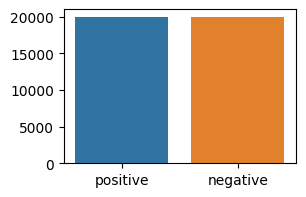

In [74]:
X = df['review'].values # Converts it into numpy array
y = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y) #stratify = y ===>positive and negative ratio of train and test data will be equal

totalcount = pd.Series(y_train).value_counts()
totalcount
plt.figure(figsize=(3, 2)) 
sns.barplot(x = np.array(['positive', 'negative']), y= totalcount.values)

plt.show()

In [61]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
  
    stop_words = set(stopwords.words('english'))
    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus_counter = Counter(word_list)
    corpus = sorted(corpus_counter, key=corpus_counter.get, reverse = True)[:1000]
    one_hot_vec_dic = {}
    for i, corp in enumerate(corpus):
        one_hot_vec_dic[corp] = i + 1
    final_x_train = []
    final_x_val = []
    
    for sentence in x_train:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_train.append(sentence_tokens)
  

    for sentence in x_val:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_val.append(sentence_tokens)  
       
    le = LabelEncoder()
    encode_train = le.fit_transform(y_train)
    encode_val = le.fit_transform(y_val)
    return final_x_train,final_x_val, encode_train, encode_val, one_hot_vec_dic
    

            
        
st = ['World is beautiful. beautiful beautiful beautiful USA is the best beautiful . I will go to USA only.']

labels = ['positive', 'negative', 'positive', 'negative', 'positive']

tockenize(st,labels,st,labels)       

X_train, X_test, Y_train, Y_test, vocab = tockenize(x_train, y_train, x_test, y_test)

In [62]:
print(X_train[0])
print(f'{len(vocab)}')\



[217, 924, 3, 182, 72, 58, 339, 470, 19, 10, 848, 393, 554, 373, 4, 293, 15, 305, 393, 14, 393, 333, 186, 129, 698, 900, 584, 575, 1, 332, 209, 10, 10, 364, 562, 29, 562, 574, 121, 602, 583, 336, 27, 100, 3, 285, 664, 10, 2, 238, 152, 100, 25, 118, 2, 100, 3, 66, 47, 101, 540, 91, 47, 68]
1000


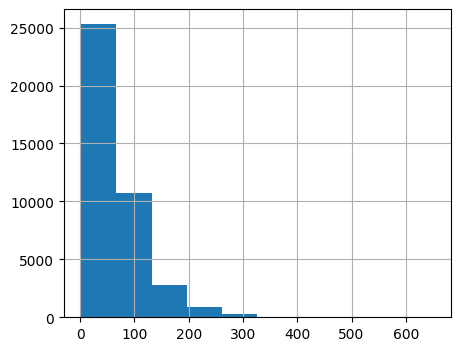

In [67]:
length_x_train = []
for i in X_train:
    length_x_train.append(len(i))

plt.figure(figsize=(5, 4)) 
pd.Series(length_x_train).hist()
plt.show()





In [96]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [97]:
x_train_pad = padding_(X_train,500)
x_test_pad = padding_(X_test,500)

In [99]:
batch_size = 128
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(Y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)